#K-Means Clustering

##Overview of Algorithm

### Summary of Findings
Overall, the k-means model does produce meaningful predictions, though it is not nearly as accurate as some of the supervised models like Naive Bayes and SVM, and is less accurate than the unsupervised NMF algorithm. The accuracy rate (relative to the Supreme Court Database topic area assignments) is roughly 50% within the training data itself, and that falls to around 45% for the test data when we use cross-validation to optimize the number of clusters. The k-means method seems to make a few specific mistakes (e.g. mis-classifying First Amendment cases as judicial power or civil rights cases) very often, which lowers the accuracy rate. Most concerningly, the algorithm has extremely low accuracy rates on 10 of the 14 topic areas on the test data (even though the overall accuracy rate of 45% seems reasonable), which implies that k-means is not a very informative model. For this reason, this is not our best model, though it seemed accurate enough to deserve an in-depth analysis.

In [70]:
%matplotlib inline
import numpy as np
import sklearn.cluster
import sklearn.feature_extraction
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import bottleneck as bn
import itertools
from sklearn.cross_validation import KFold
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

###Multi-Purpose Functions for Evaluating Models
We can start by defining a couple of generally useful functions to evaluate the correctness of any given set of predictions.

In [16]:
# computes % accuracy rate of predictions, given a vector of predicted categories and a vector of actual categories
def accuracy(predicted,actual):
    # boolean array of Trues for correct predictions and Falses for incorrect predictions
    correct = map(lambda (c1,c2) : c1==c2, zip(predicted,actual))
    return float(sum(correct)) / len(correct)

Another way to measure the success of an unsupervised algorithm is the Rand Index, which is described in much more detail in the NMF notebook. In short, we can look at every possible pair of cases, and mark that pair as a 'success' if the k-means clustering dealt with the pair successfully (i.e. either placed them into the same cluster when they were supposed to be together, or placed them in separate clusters when they were supposed to be separate), and a 'failure' otherwise. Then, the Rand Index is defined as $\frac{\text{number of successes}}{\text{number of successes} + \text{number of failures}}$.

In [17]:
# computes the Rand Index, given a vector of predicted categories and a vector of actual categories
def rand_index(predicted,actual):
    # use itertools to create pairs of documents, using the k-means clusters and SCDB categories
    cluster_pairs_pred = itertools.product(predicted,predicted)
    cluster_pairs_actual = itertools.product(actual,actual)
    # loop through all document pairs to compute tp, tn, fp, and fn
    (tp,tn,fp,fn) = 0, 0, 0, 0
    for pair1,pair2 in zip(cluster_pairs_pred, cluster_pairs_actual):
        if (pair1[0]==pair1[1]):
            if (pair2[0]==pair2[1]):
                tp += 1
            else:
                fp += 1
        else:
            if (pair2[0]==pair2[1]):
                fn += 1
            else:
                tn += 1
    
    # compute and output Rand Index using formula from above
    rand_index_train = float(tp+tn)/(tp+tn+fp+fn)
    return rand_index_train

##Fitting Noun Model with Training Data

We start by fitting a model with just nouns on the training data. First, we apply a TF-IDF transform (which is described elsewhere in our project) to the data, to place a higher importance on words that are not extremely common.

In [3]:
%%time
# read in training data from csv
noun_train_mat = np.loadtxt("noun_train_mat.csv", delimiter = ",")
# use TF-IDF to scale each document's vector to have norm 1 and place a lower weight on very common words
tf_idf_fit = sklearn.feature_extraction.text.TfidfTransformer().fit(noun_train_mat)
noun_train_mat = tf_idf_fit.transform(noun_train_mat).toarray()

Wall time: 34.2 s


Next, we can fit a k-means model with 14 clusters on the training data. We can also compute and output the ratio of within-cluster SSQ to total SSQ, where within-cluster SSQ is defined as the total squared distance of each point to the center of its assigned cluster across all training data, and total SSQ is the total squared distance of each point to the mean of all of the data.

In [5]:
%%time
kmeans_fit = sklearn.cluster.KMeans(n_clusters=14).fit(noun_train_mat)
# compute the ratio of within-group sum of squared distances to cluster mean to total sum of squared distances to overall mean
ssq = sum(np.var(noun_train_mat,0))*len(noun_train_mat)
within_ssq = sum(map(lambda r : min(r)**2, kmeans_fit.transform(noun_train_mat)))
print within_ssq / ssq

0.929438894343
Wall time: 18.4 s


That ratio gives us an indication of how well the clusters predict the variance in the data. However, the fact that it is very high is not a cause of concern by itself; we are dealing with a vector space whose dimension is well over 10,000, so it would be unrealistic to expect the variance to fall dramatically if we use 14 clusters, even if those clusters are very meaningful and useful.

We can use that k-means fit to divide the training data cases into 14 documents.

In [6]:
%%time
# use the fit above to cluster the data
clusters = kmeans_fit.predict(noun_train_mat)
cluster_lists = [[i for i,j in enumerate(clusters) if j==cluster] for cluster in range(14)]
print 'Number of documents per cluster:', [len(clusters[clusters==i]) for i in range(14)]

Number of documents per cluster: [44, 45, 39, 346, 60, 166, 43, 24, 70, 90, 63, 30, 46, 21]
Wall time: 82 ms


###Key Words for Each Cluster

Using the TF-IDF-transformed `noun_train_mat` matrix from above, we can find out the words that are most prominent for each cluster.

In [7]:
# load vocab from csv
noun_vocab = np.loadtxt("noun_vocab.csv", delimiter=",", dtype="str")
noun_vocab = [(int(i),j) for i,j in noun_vocab]
id2noun = dict(noun_vocab)

In [8]:
# find and output the 5 most important words for each category
num_best = 5
best_indices = map(lambda cases : list(bn.argpartsort(-sum(noun_train_mat[cases]),num_best)[0:num_best]), cluster_lists)
best_words = [[id2noun[i] for i in lst] for lst in best_indices]
best_words

[['commission', 'rate', 'commerce', 'gas', 'carrier'],
 ['trial', 'jury', 'court', 'petitioner', 'judge'],
 ['act', 'liability', 'employer', 'railroad', 'employee'],
 ['court', 'district', 'law', 'state', 'petitioner'],
 ['state', 'tax', 'property', 'income', 'court'],
 ['land', 'respondent', 'act', 'court', 'water'],
 ['conviction', 'offense', 'court', 'conspiracy', 'felony'],
 ['alien', 'immigration', 'deportation', 'nationality', 'act'],
 ['court', 'sentence', 'counsel', 'habea', 'trial'],
 ['court', 'search', 'trial', 'petitioner', 'amendment'],
 ['union', 'labor', 'board', 'employee', 'bargain'],
 ['student', 'school', 'board', 'education', 'court'],
 ['pension', 'plan', 'benefit', 'security', 'child'],
 ['master', 'decree', 'court', 'orig ', 'u s ']]

Just as with most of the other models, these word groups are generally very meaningful and useful; for example, `['trial', 'jury', 'court', 'petitioner', 'judge']` clearly must include cases relate to judicial law, while `['conviction', 'offense', 'court', 'conspiracy', 'felony']` deals with criminal law.

###Comparing with Supreme Court Database's Topic Areas

To evaluate the effectiveness of the algorithm (on the training data), we need to include the Supreme Court Database data. As before, the computations and visualizations in this section are very similar to those in the NMF notebook.

In [9]:
# read in SC Database's issue areas from csv
train_issue_areas = np.loadtxt("train_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
train_issue_areas = train_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in train_issue_areas]) for i in range(14)]

Number of documents per category: [238, 186, 84, 43, 10, 9, 56, 234, 126, 57, 10, 30, 4, 0]


In [22]:
topic_areas = ['Criminal Procedure', 'Civil Rights', 'First Amendment', 'Due Process', 'Privacy', 'Attorneys', 'Unions',
               'Economic Activity', 'Judicial Power', 'Federalism', 'Interstate Relations', 'Federal Taxation', 'Miscellaneous',
               'Private Action']

We need to take the 14 k-means clusters and map each one of them to SCDB topic area, so that we can place each data point into a Supreme Court Database category. Here, we use a method that is based on 'assignment method 1' in the NMF notebook. The algorithm is described in detail there; in short, for each k-means cluster, we assign that cluster to the SCDB category that has the most cases in common with the k-means cluster.

In [23]:
# create a 14x14 matrix (where each row is a k-means cluster and each column is an SCDB cluster) measuring the degree of
# related-ness between each cluster pair
compare_mat = map(lambda r : map(int, r), np.zeros((14,14)))
# first, assign the (i,j) element in the matrix to the number of cases in k-means cluster i and SCDB cluster j, for each (i,j)
for i,j in zip(clusters, train_issue_areas):
    compare_mat[i][j] += 1
# normalize each row to have a sum of 1
compare_mat = map(lambda row : map(float,row) / sum(row), np.array(compare_mat))

# assign each k-means cluster to a (not necessarily unique) SCDB cluster by picking the highest element of each row of compare_mat
assignments = map(np.argmax, compare_mat)
print assignments

[7, 0, 7, 8, 7, 7, 0, 1, 0, 0, 6, 1, 1, 10]


Now, we can use that output to convert the k-means clusters produced from the model above into an assignment of each case to an SCDB topic area. We can then produce the accuracy rate (defined as the proportion of cases that are assigned to the correct SCDB category) and a Rand Index for the prediction.

In [24]:
# use the assignments above to convert the clusters into equivalent SCDB categories for each document
new_clusters = map(lambda cluster : assignments[cluster], clusters)
# compute and output accuracy rate
print 'Accuracy:', accuracy(new_clusters, train_issue_areas)
print 'Rand Index:', rand_index(new_clusters, train_issue_areas)

Accuracy: 0.497700091996
Rand Index: 0.754519626023


####Visualizing Results on Training Data

The following visualizations are all based directly on on the NMF notebook, and are described in depth in that notebook. First, we produce a heat map that illustrates the clustering above, by counting how many cases were clustered into SCDB area `i` and were actually in SCDB topic area `j`, for each pair of topic areas `(i,j)`.

C:\Users\Madhu\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


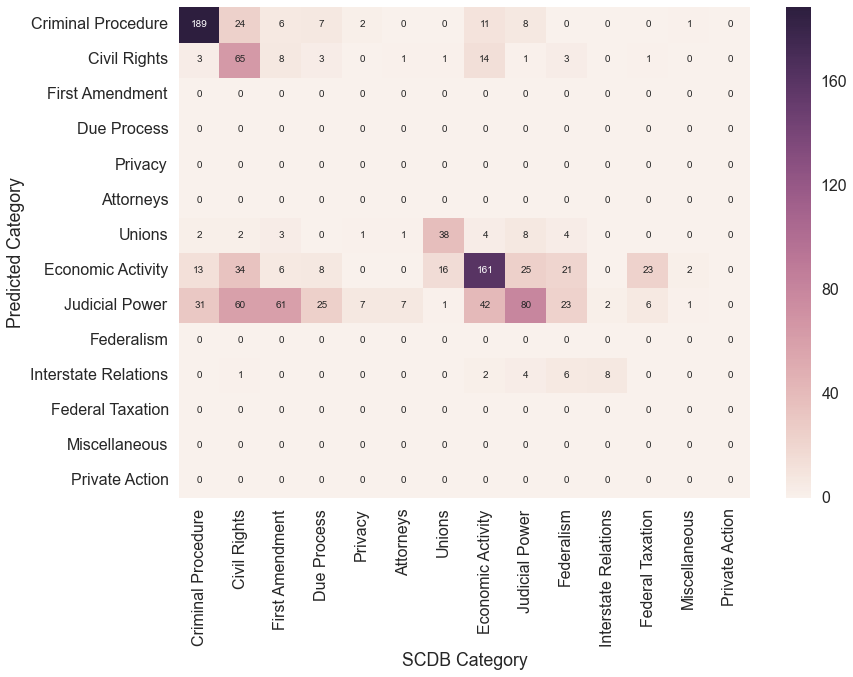

In [25]:
compare_mat_new = map(lambda r : map(int, r), np.zeros((14,14)))
for i,j in zip(new_clusters, train_issue_areas):
    compare_mat_new[i][j] += 1
sns.heatmap(compare_mat_new, annot=True, xticklabels=topic_areas, yticklabels=topic_areas, fmt='d')
sns.axlabel('SCDB Category', 'Predicted Category')

The next heat map is the same as above, but with each column normalized to have a sum of 1, which helps us analyze percent accuracy rates within each topic area.

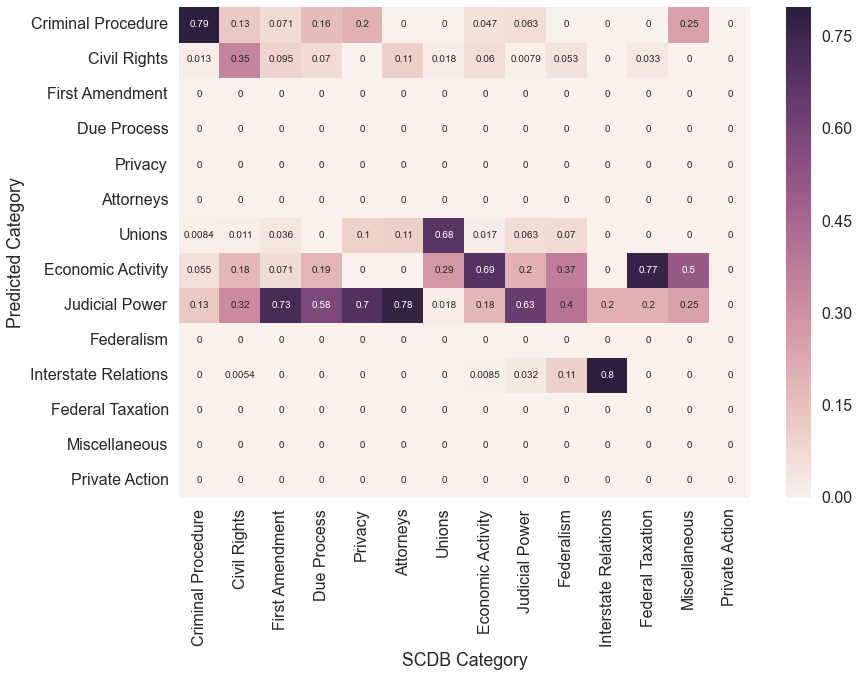

In [26]:
# normalize each column to have a sum of 1
compare_mat_new = np.array(compare_mat_new).T
compare_mat_new = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat_new))
compare_mat_new = np.array(compare_mat_new).T

# produce a heat map of the new normalized matrix
sns.heatmap(compare_mat_new, annot=True, xticklabels=topic_areas, yticklabels=topic_areas)
sns.axlabel('SCDB Category', 'Predicted Category')

Once again, this helps us understand the most common mistakes made by the algorithm. For example, federal taxation cases are often mis-classified as economic activity, and First Amendment, due process, privacy, and attorneys cases are all frequently mis-classified as judicial power cases.

The following bar chart displays the accuracy rate of the k-means clustering for the cases within each SCDB category, for the training data.

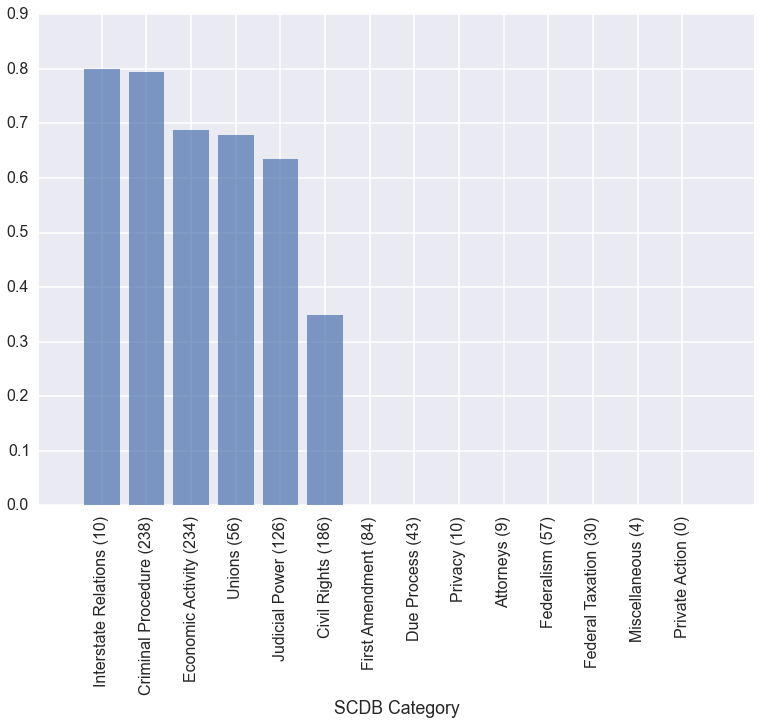

In [27]:
# sort the SCDB topic areas based on accuracy on training data
ordered = zip(topic_areas, [sum([x==i for x in train_issue_areas]) for i in range(14)], np.diag(compare_mat_new), range(14))
ordered.sort(key = lambda (topic,num,acc,ind) : -acc)
ordered_topics = list(zip(*ordered)[0])
counts = list(zip(*ordered)[1])
topic_accuracies = list(zip(*ordered)[2])
order = list(zip(*ordered)[3])

# plot a bar chart of the accuracy of the clustering algorithm within each topic area
fig, ax = plt.subplots()
ax.bar(np.arange(14)+1, topic_accuracies, alpha=0.7, linewidth=0)
ax.set_xticks(np.arange(14)+1.4)
ax.set_xticklabels(map(lambda (count,topic) : "%s (%s)" % (topic,count), zip(counts,ordered_topics)), rotation='vertical')
ax.set_xlabel('SCDB Category')
print

As before, this bar chart shows that the accuracy rate is high for some of the largest categories, but is zero for several categories (since no cases end up being placed into those clusters). This is worrying, especially since some of the larger areas (like First Amendment) are also left out.

##Cross-Validation

Now, we can use the methods produced in the NMF.ipynb file to do 5-fold cross-validation on the k-means model. The following function is described in detail in NMF.ipynb.

In [28]:
def cv_results_unsupervised(predict, x, y, score_func, nfolds=5):
    results = []
    for train, test in KFold(len(y), nfolds):
        pred = predict(x[train],y[train],x[test]) # compute predictions
        results += [score_func(pred, y[test])] # evaluate score function on held-out data
    return results

This `fit_transform` function is similar to the version in NMF.ipynb, but is not identical (since it has to compute predictions based on a k-means model instead of NMF). In short, the function fits a k-means model with `n_components` clusters on the data in `x_train` and `y_train`, and use that to predict clusters for `x_test`.

In [30]:
def fit_transform(x_train, y_train, x_test, n_components):
    # compute an NMF fit on x_train, and produce
    kmeans_fit = sklearn.cluster.KMeans(n_clusters=n_components).fit(x_train)
    clusters_train = kmeans_fit.predict(x_train)
    
    # create a 14x14 matrix (where each row is an NMF cluster and each column is an SCDB cluster) measuring the degree of
    # related-ness between each cluster pair
    compare_mat = map(lambda r : map(int, r), np.zeros((n_components,14)))
    # first, assign the (i,j) element in the matrix to the number of cases in NMF cluster i and SCDB cluster j, for each (i,j)
    for i,j in zip(clusters_train, y_train):
        compare_mat[i][j] += 1
    assignments = map(np.argmax, compare_mat)
    
    clusters_test = kmeans_fit.predict(x_test)
    # use the assignments above to convert the clusters into equivalent SCDB categories for each document
    new_clusters = map(lambda cluster : assignments[cluster], clusters_test)
    return new_clusters

We can use those functions to do 5-fold cross-validation with several possible parameter choices, in the same manner as we do in NMF.ipynb.

In [48]:
%%time
num_clusters_lst = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

results = dict()
for k in num_clusters_lst:
    print 'Testing with %d clusters' % k
    results[k] = cv_results_unsupervised(lambda x,y,z : fit_transform(x,y,z,k), noun_train_mat, train_issue_areas,
                                         lambda pred,act : (accuracy(pred,act), rand_index(pred,act)), nfolds=5)

Testing with 5 clusters
Testing with 10 clusters
Testing with 15 clusters
Testing with 20 clusters
Testing with 25 clusters
Testing with 30 clusters
Testing with 35 clusters
Testing with 40 clusters
Testing with 45 clusters
Testing with 50 clusters
Testing with 55 clusters
Testing with 60 clusters
Wall time: 19min 12s


In [49]:
# output 2 dictionaries containing the average accuracy and average Rand Index for each value of n_clusters, based on the
# cross-validation results from above
results_accuracies = dict()
results_rand_ind = dict()
for k in results.keys():
    accuracy_k, rand_index_k = zip(*results[k])
    results_accuracies[k] = np.mean(accuracy_k)
    results_rand_ind[k] = np.mean(rand_index_k)
print results_accuracies
print results_rand_ind

{35: 0.47095928634845469, 5: 0.40567369889654598, 40: 0.44617173297256157, 10: 0.44155498245465691, 45: 0.47376231344861114, 15: 0.43053312476218658, 50: 0.45811947744472159, 20: 0.45064051071745659, 55: 0.48113981313152665, 25: 0.48574810806240221, 60: 0.48019701517777869, 30: 0.48299158669090597}
{35: 0.71561083968792727, 5: 0.62507299691337459, 40: 0.71358680298106325, 10: 0.68737749160375983, 45: 0.74361063564992569, 15: 0.64382070960299465, 50: 0.74314918860191514, 20: 0.68163880984250425, 55: 0.73836026323526149, 25: 0.71789171453800193, 60: 0.76229402610667241, 30: 0.73028526735111776}


The following line chart shows the relationship between the number of clusters (on the $x$-axis) and the average accuracy and average Rand Index on the validation data (on the $y$-axis), to help visualize which parameter choice seems optimal.

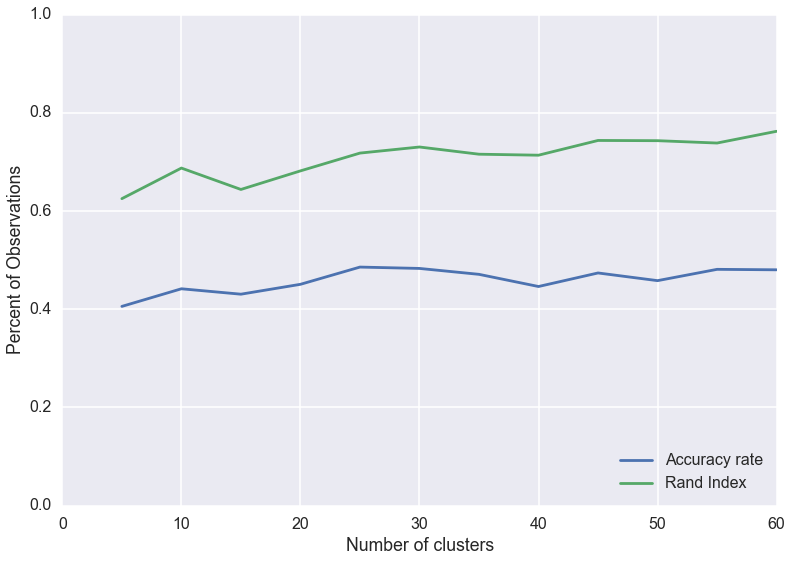

In [50]:
accuracies = results_accuracies.items()
accuracies.sort(key = lambda (a,b) : a)
plt.plot(*zip(*accuracies), label='Accuracy rate')

rand = results_rand_ind.items()
rand.sort(key = lambda (a,b) : a)
plt.plot(*zip(*rand), label='Rand Index')

plt.ylim((0,1))
plt.xlabel('Number of clusters')
plt.ylabel('Percent of Observations')
plt.legend(loc = 'lower right')

##Choose Best Model and Run on Test Data

###Choose Optimal Number of Clusters

As described in NMF.ipynb, there are two possible ways for us to choose the optimal number of clusters: we can use the accuracy rate or the Rand Index. It would probably make more sense to use the accuracy rate, since that is the most easily interpretable measure of prediction accuracy.

In [53]:
n_clusters = results_accuracies.keys()[np.argmax(results_accuracies.values())]
n_clusters

25

In [52]:
n_clusters = results_rand_ind.keys()[np.argmax(results_rand_ind.values())]
n_clusters

60

###Fit Model with Optimal Parameter and Apply to Test Data

As before, we can load in the test data and apply a TF-IDF transform, keeping in mind that we have to use the TF-IDF fit from the training data rather than re-fitting it on the test data.

In [54]:
%%time
# read in test data from csv
noun_test_mat = np.loadtxt("noun_test_mat.csv", delimiter = ",")
# use TF-IDF fit from training data to scale each document's vector to have norm 1 and place a lower weight on very common words
noun_test_mat = tf_idf_fit.transform(noun_test_mat).toarray()

Wall time: 16.1 s


Now, we can use the `fit_transform` function from above, using the optimal number of clusters (which was 25 when we ran this), to cluster each case in the test data into one of the SCDB categories using a k-means model fit from the training data.

In [63]:
%%time
# vector of predicted SCDB categories for each element of the test set
clusters_test = fit_transform(noun_train_mat, train_issue_areas, noun_test_mat, n_clusters)
# list of lists of the cases that got clustered into each of the 14 categories
cluster_lists_test = [[i for i,j in enumerate(clusters_test) if j==cluster] for cluster in range(14)]
print 'Number of documents per cluster:', [len(cluster_lists_test[i]) for i in range(14)]

Number of documents per cluster: [105, 160, 4, 0, 0, 0, 26, 185, 17, 11, 0, 0, 0, 0]
Wall time: 37.9 s


###Evaluate Test Data Results Using SC Database Categories

We can now compare the test data clusters computed above to compute the accuracy and Rand Index of our predictions on the test data.

In [64]:
# read in SC Database's issue areas from csv
test_issue_areas = np.loadtxt("test_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
test_issue_areas = test_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in test_issue_areas]) for i in range(14)]

Number of documents per category: [104, 97, 38, 15, 3, 6, 26, 104, 68, 24, 5, 17, 1, 0]


In [65]:
# compute and output accuracy rate and Rand Index
print 'Accuracy:', accuracy(clusters_test, test_issue_areas)
print 'Rand Index:', rand_index(clusters_test, test_issue_areas)

Accuracy: 0.448818897638
Rand Index: 0.71567518135


The following visualizations are all based on NMF.ipynb, as before.

This is a heat map of the same format as above, in which the element at row `i` and column `j` is the number of cases from SCDB category `j` that were classified as category `i`.

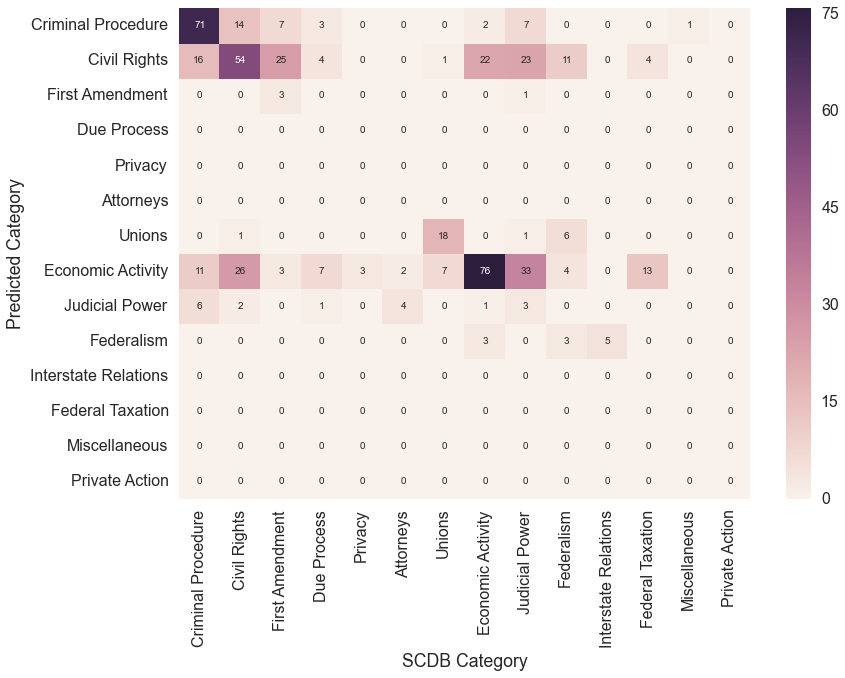

In [66]:
compare_mat_test = map(lambda r : map(int, r), np.zeros((14,14)))
for i,j in zip(clusters_test, test_issue_areas):
    compare_mat_test[i][j] += 1

sns.heatmap(compare_mat_test, annot=True, xticklabels=topic_areas, yticklabels=topic_areas, fmt='d')
sns.axlabel('SCDB Category', 'Predicted Category')

This heat map is the same as above, but with each column normalized to have a sum of 1.

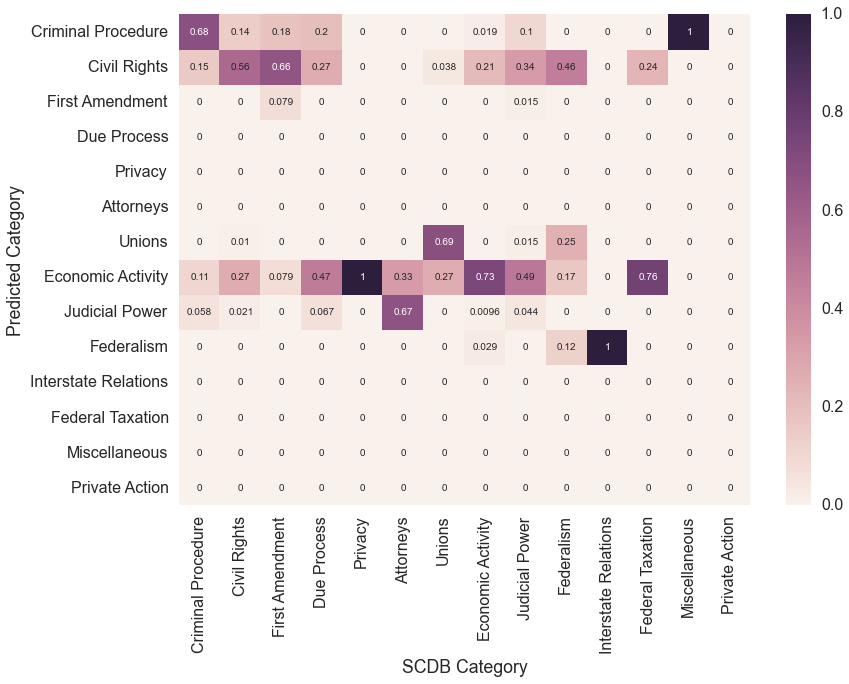

In [67]:
# normalize each column to have a sum of 1
compare_mat_test = np.array(compare_mat_test).T
compare_mat_test = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat_test))
compare_mat_test = np.array(compare_mat_test).T

# produce a heat map in which the element in row i and column j represent the proportion of cases in the testing set from SCDB
# category j that get placed in category i by the clustering algorithm (trained on the training data with the optimal parameter)
sns.heatmap(compare_mat_test, annot=True, xticklabels=topic_areas, yticklabels=topic_areas)
sns.axlabel('SCDB Category', 'Predicted Category')

The sources of error are similar to what they were before (with some exceptions). For example, attorneys cases tend to be mis-classified as judicial power cases, and First Amendment cases are often mis-classified as civil rights cases.

Finally, this bar chart shows the prediction accuracy within each topic area, on the test data

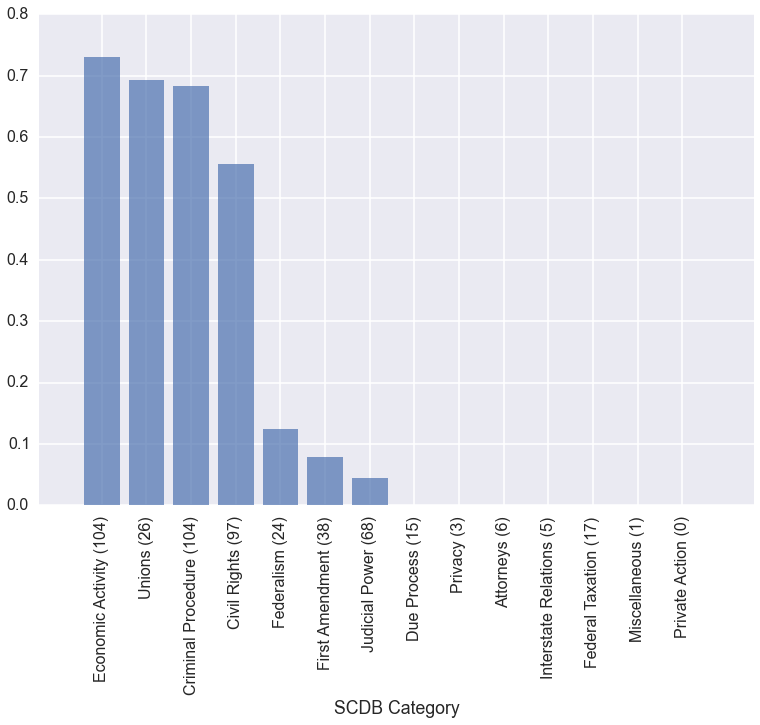

In [68]:
# sort the SCDB topic areas based on accuracy on testing data
ordered = zip(topic_areas, [sum([x==i for x in test_issue_areas]) for i in range(14)], np.diag(compare_mat_test), range(14))
ordered.sort(key = lambda (topic,num,acc,ind) : -acc)
ordered_topics = list(zip(*ordered)[0])
counts = list(zip(*ordered)[1])
topic_accuracies = list(zip(*ordered)[2])
order = list(zip(*ordered)[3])

# plot a bar chart of the accuracy of the clustering algorithm within each topic area
fig, ax = plt.subplots()
ax.bar(np.arange(14)+1, topic_accuracies, alpha=0.7, linewidth=0)
ax.set_xticks(np.arange(14)+1.4)
ax.set_xticklabels(map(lambda (count,topic) : "%s (%s)" % (topic,count), zip(counts,ordered_topics)), rotation='vertical')
ax.set_xlabel('SCDB Category')
print

Overall, this bar chart is very concerning and does not bode well for the success of the k-means model. The model does do reasonably well on some of the large categories, like economic activity and criminal procedure. However, the performance is dismal for some of the other significant categories (like judicial power), and is zero for half of the categories.

##Trying Other Parts of Speech

Since all of the work done in this notebook has been for nouns alone, we can also try using other parts of speech. The following `evaluate` function is based on the corresponding function in NMF, and compute the accuracy and Rand Index for the predictions of a k-means model that is trained and tested on the same set (since we're just doing a simple heuristic test and eyeballing the accuracy rates to look for huge improvements.

In [71]:
def evaluate(x_files, y_data, n_clusters):
    # read in text data
    x_data = map(lambda x_file : np.loadtxt(x_file, delimiter=','), x_files)
    x_data = reduce(lambda x1,x2 : np.concatenate((x1,x2),1), x_data)
    
    # use TF-IDF to scale each document's vector to have norm 1 and place a lower weight on very common words
    tf_idf_fit = sklearn.feature_extraction.text.TfidfTransformer().fit(x_data)
    x_data = tf_idf_fit.transform(x_data).toarray()
    
    # compute k-means fit
    kmeans_fit = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(x_data)
    # list of cluster assignments for the cases
    clusters = kmeans_fit.predict(x_data)
    
    # create a (n_clusters x 14) matrix (where each row is an k-means cluster and each column is an SCDB cluster) measuring the
    # degree of related-ness between each cluster pair
    compare_mat = map(lambda r : map(int, r), np.zeros((n_clusters,14)))
    # first, assign the (i,j) element in the matrix to the number of cases in k-means cluster i and SCDB cluster j, for each
    # (i,j) pair
    for i,j in zip(clusters, y_data):
        compare_mat[i][j] += 1
    # normalize each row to have a sum of 1
    compare_mat = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat))

    # assign each k-means cluster to a SCDB cluster by picking the highest element of each row of compare_mat
    assignments = map(np.argmax, compare_mat)
    
    # use the assignments above to convert the clusters into equivalent SCDB categories for each document
    new_clusters = map(lambda cluster : assignments[cluster], clusters)
    
    return (accuracy(new_clusters, y_data), rand_index(new_clusters, y_data))

The following cells show the accuracy rates and Rand Indices when using other parts of speech (verbs, adjectives, foreign words, and precedents) alone, and using a few combinations of parts of speech. These combinations are the same ones used in NMF.ipynb, and the rationale is explained in that notebook.

In [76]:
%%time
evaluate(['verb_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 18.8 s


(0.3403863845446182, 0.6428173047871093)

In [75]:
%%time
evaluate(['adj_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 10.3 s


(0.32842686292548295, 0.5854308973915192)

In [73]:
%%time
evaluate(['for_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 1.62 s


(0.25390984360625574, 0.33086091459745476)

In [74]:
%%time
evaluate(['prec_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 15.9 s


(0.26310947562097514, 0.2777366366246914)

In [77]:
%%time
evaluate(['noun_train_mat.csv','verb_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 1min 9s


(0.49494020239190434, 0.7098332810017866)

In [78]:
%%time
evaluate(['noun_train_mat.csv','adj_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 1min


(0.49310027598896045, 0.7275927178184262)

In [79]:
%%time
evaluate(['noun_train_mat.csv','prec_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 1min 6s


(0.47930082796688134, 0.7209811699528339)

In [80]:
%%time
evaluate(['noun_train_mat.csv','verb_train_mat.csv','adj_train_mat.csv','for_train_mat.csv','prec_train_mat.csv'],
         train_issue_areas, n_clusters=n_clusters)

Wall time: 1min 25s


(0.49586016559337626, 0.7756000707533797)

The models with a single part of speech other than nouns do not do very well; the best one uses verbs and produces an accuracy rate of roughly 34%, which is much lower than the noun accuracy rate around 50% (when we ran this). Even the part-of-speech combinations (which are: nouns and verbs; nouns and adjectives; nouns and precedents; and all 5 parts of speech together) produce accuracy rates that are comparable to or slightly worse than using nouns alone.

Therefore, we would not gain very much by adding in other parts of speech, so we decided to stick with nouns instead of using any of these other choices to do a complete round of cross-validation and testing.